# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [62]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [63]:
# using SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\sujpanda\\Desktop\\applied\\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [64]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [65]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [66]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [67]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [68]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [69]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [70]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [71]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [72]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [73]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [74]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [75]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [76]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [77]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [78]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [79]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [80]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [81]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [82]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [83]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:02<00:00, 2091.11it/s]


In [84]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [85]:
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 2812.55it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [86]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [87]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [88]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [89]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [90]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.9952961802482605), ('especially', 0.9938456416130066), ('regular', 0.9937968850135803), ('amazing', 0.9937533140182495), ('calorie', 0.9936224818229675), ('overall', 0.993571937084198), ('healthy', 0.9934845566749573), ('alternative', 0.9933762550354004), ('looking', 0.9933747053146362), ('snack', 0.9933668971061707)]
[('varieties', 0.9994357228279114), ('eaten', 0.9994240403175354), ('stash', 0.9994170069694519), ('beef', 0.9993213415145874), ('become', 0.9992537498474121), ('particularly', 0.9992130994796753), ('somewhat', 0.9992072582244873), ('de', 0.9991826415061951), ('remember', 0.9991679191589355), ('bar', 0.999157726764679)]


In [91]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [92]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:05<00:00, 850.00it/s] 


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [93]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [94]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:38<00:00, 130.75it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

### some utility functions

In [95]:
def printWordCloud(df,input=26):
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud, STOPWORDS
    i = 0
    for i in range(input):  
        wordslist = df[df['labels'] == i]['desc']
        print("word list for label = ",i)
        print(wordslist)
        if not wordslist.values[0]:
            print("Word cloud is not supported for label : ",i)
            continue
        if(len(wordslist) > 0):
            stringlist = " ".join(wordslist)            
            wordcloud = WordCloud(relative_scaling = 1.0,
                      stopwords = set(STOPWORDS)
                      ).generate(stringlist)
            plt.imshow(wordcloud)
            plt.axis("off")
            plt.title("cluster number " + str(i))
            plt.show()

In [96]:
def kmeanWithK(vects):
    from sklearn.cluster import KMeans
    Sum_of_squared_distances = []
    K = [2,3,4,5,10,15,20,25,30,35,40,45,50]
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(vects)
        Sum_of_squared_distances.append(km.inertia_)
        
    
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [97]:
def aggloWihtK(vects):
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.metrics import silhouette_samples, silhouette_score
    avg_score = []
    K = [2,3,4,5,10,15,20,25,30,35,40,45,50]
    for k in K:
        agg = AgglomerativeClustering(n_clusters=k)
        pred = agg.fit_predict(vects)
        silhouette_avg = silhouette_score(vects, pred)
        print("For n_clusters =", k,"The average silhouette_score is :", silhouette_avg)
        avg_score.append(silhouette_avg)
    print("The max silhouette_avg is ",max(avg_score))

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

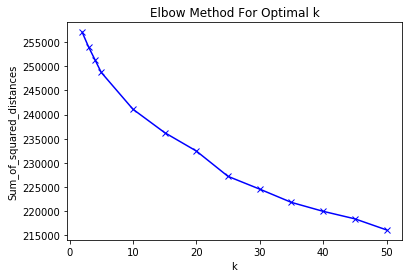

In [98]:
kmeanWithK(final_counts)

In [100]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25, random_state=0).fit(final_counts)

In [101]:
newproce_reviews = np.asarray(preprocessed_reviews)

In [102]:
labels = kmeans.labels_

In [103]:
df = pd.DataFrame({'desc':newproce_reviews, 'labels':labels})

In [104]:
df.head()

desc  labels
0  product available victor traps unreal course t...       3
1  used victor fly bait seasons ca not beat great...       3
2  received shipment could hardly wait try produc...       3
3  really good idea final product outstanding use...       3
4  glad cocker standard poodle puppy loves stuff ...       3

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

word list for label =  0
1241    switched merrick dog food several years ago do...
1934    year old portuguese water dog always seemed se...
Name: desc, dtype: object


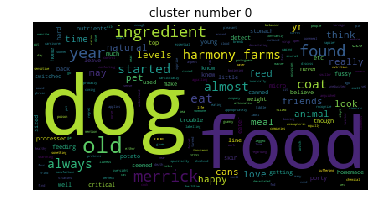

word list for label =  1
7       shipped day ordered arrived within days live o...
35      first tasted sauce visiting alaska served fish...
41      not purchase product amazon purchased oz bottl...
100     although seems like great product definitely n...
101     made mistake believing science diet best choic...
117     charlee bears small low calorie use en masse t...
120     hit pups price calories piece not beat great t...
128     something eat starving please give real food h...
131     not believe many ways product saved life gave ...
168     recently low carb diet find no longer tolerate...
171     not like using artificial sweeteners chemicals...
175     hooked stevia not natural tastes great truly g...
179     used buy product size health food store florid...
183     nustevia white stevia powder amazing low carb ...
189     went searching charcoal dog biscuits reading h...
208     not great plain wonderful mixed herbs little b...
218     reading earlier reviews genuine chinese

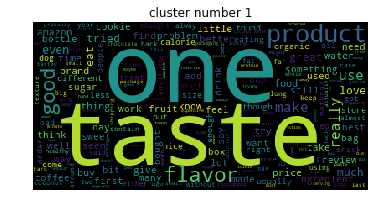

word list for label =  2
760     yuban makes best cup coffee either roast never...
1731    surprised much tastes like coffee completely a...
2201    primary point review note packaging less expen...
3073    becoming coffee person trying various brands f...
3077    pleased new coffee thanx another user comment ...
3250    coffee two strikes decaf already ground use de...
3251    riviera sunset decaffinated coffee melitta caf...
3255    reviewers say coffee bitter like bitter not li...
3257    far tea drinker coffee drinker not start day w...
3264    not much coffee drinker mainly not drink caffe...
3267    coffee excellent smooth taste pleasant aroma n...
3270    coffee fan drinks coffee black nothing added a...
3273    big coffee drinker much better judgement due s...
3274    coffee lover one pleasures life excited review...
3287    melitta riviera sunset decaf makes better dece...
3290    pretty decent coffee pre ground decaf coffee s...
3299    melitta not sell good coffee grew using

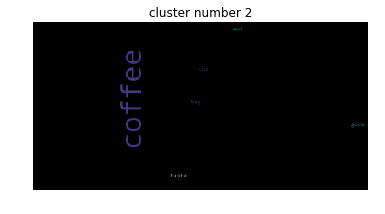

word list for label =  3
0       product available victor traps unreal course t...
1       used victor fly bait seasons ca not beat great...
2       received shipment could hardly wait try produc...
3       really good idea final product outstanding use...
4       glad cocker standard poodle puppy loves stuff ...
6       nine cats crazy kibbles last thing want cat fo...
12      get busy home like sausage lot quick meal opti...
15      thank goodness mexgrocer love pico pica sauce ...
16      different sauce nothing like anything find gro...
17      found product search edible gold leaf decided ...
18      purchased item cake called gold dust never tho...
19      used product multiple times fact purchased fou...
20      used super gold luster dust create exquisite c...
21      product allows make really big splashes provid...
22      cute affordable set son golf theme party great...
24                                                       
25      golf set arrived quickly pictured birth

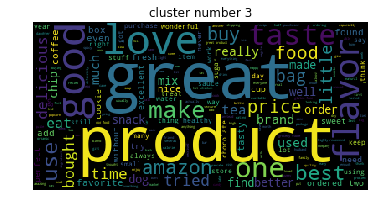

word list for label =  4
1823    love green tea impressed green tea powder inst...
2089    every revolution product tried wonderful exper...
3102    okay not hot tea perfect loose leaf tea iced t...
3233    ordered source past cancelled membership due e...
3651    first let state brew tea gaiwan hence use loos...
4180    like loose tea not like chewing leaves tea cup...
Name: desc, dtype: object


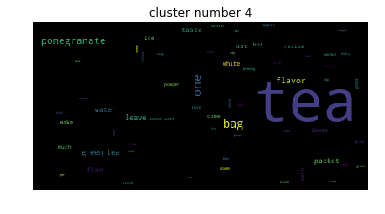

word list for label =  5
1827    first part review history health problems gree...
3421    drinking royal king natural organic green tea ...
Name: desc, dtype: object


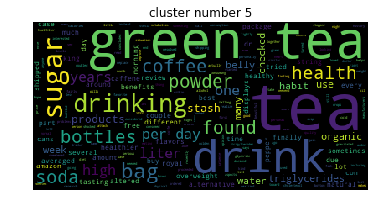

word list for label =  6
702    happy amazon got back could order second case ...
Name: desc, dtype: object


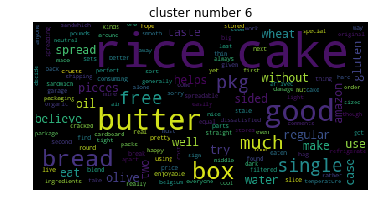

word list for label =  7
597    one fifty families chosen receive nabisco oreo...
610    get older fatter seek opportunities eat snacks...
611    still six years away centennial oreo cookie fi...
Name: desc, dtype: object


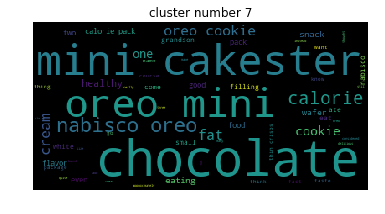

word list for label =  8
113     not south live sofla sometimes get southern in...
249     received whole package delicious tasty perfect...
642     baked first batch muffins pleased easy make ta...
644     product comes good company makes number excell...
648     bought local grocery store wish would read rev...
649     muffins not win prizes flavor agree reviewers ...
651     folks comparing hodgson blueberry muffin mix o...
652     really excited surprised found mix local wal m...
657     family really liked muffins also made vacation...
658     recently discovered sensitivities dairy wheat ...
671     big fan hodgson mill products love bread mixes...
1054    growing mother always made apple sauce cake ev...
1075    like reviewers love seasoning making cajun cat...
1191    used mix make cake glass pan using grapeseed o...
1224    bought pomegranate molasses make fattoush deli...
1957    two terrier mixes love product mix dry grain f...
1981    pancake mix go not buttermilk fridge no

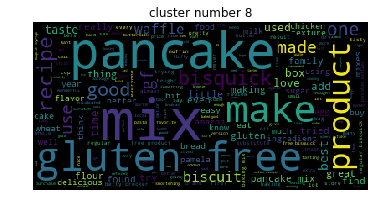

word list for label =  9
82      though coffee expensive compared regular store...
140     husband took vacation costa rica wonderful tim...
143     first tasted coffee hotel coffee shop costa ri...
144     coffee smoothest dark roast coffee ever tasted...
145     forget starbucks peets anything else real deal...
146     husband fell love cafe britt coffee costa rica...
147     love coffee like reviewers took trip costa ric...
353     rarely want eat much first arise morning coffe...
731     coffee company delivers great coffee taste lik...
756     like strong coffee flavor exceptional not foun...
758     husband always searching better coffee seeming...
759     excellent enjoyed yuban coffee many years rece...
761     living baton rouge wife drank popular regional...
764     recently thought coffee coffee apparently not ...
1903    wimpy coffee drinkers beware not bean like str...
2132    visiting friend nate morning coffee came stora...
2194    love coffee wish came already ground no

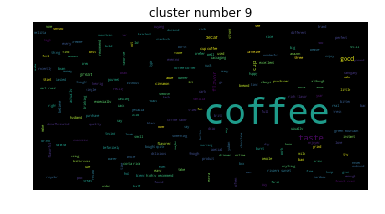

word list for label =  10
337     wanted give soy crisps justice stars ordering ...
833     always fan kettle chips open bag kettle chips ...
866     may sound rediculous actually ordered wrong br...
873     got sea salt vinegar chips kettle used salt vi...
910     kettle brand chips crunchy would say regular p...
911     loved chips chips would buy discovered england...
924     kettle chips really careful flavors nauseating...
950     addicted salty tangy flavors opened first bag ...
954     addicted salty tangy flavors opened first bag ...
955     oregonian make point sharing oregon made snack...
986     honey dijon chips bring terrific balance salty...
2879    bought uncle ray wavy oz potato chips purchase...
Name: desc, dtype: object


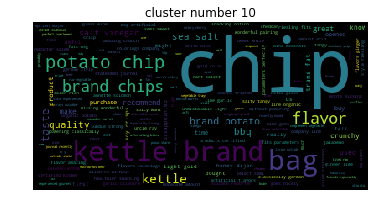

word list for label =  11
95    review make sound really stupid whatever not r...
Name: desc, dtype: object


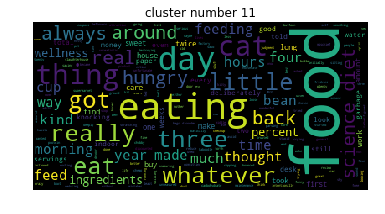

word list for label =  12
127     buy cookies not regret hands best store bought...
182     used use agave nectar honey even though picked...
567     tried milk chocolate hazelnuts first time rece...
576     hate admit miss lard one class unscrewed oreo ...
605     one reviewer writes oreo crackers without crem...
1145    cadbury chocolate uses different formula count...
1146    us made version cadbury chocolate distinct tas...
1189    chocolate cake fantastic reason think would we...
1251    milka naps mix gift box fun unique gift tired ...
1264    consume jar every two weeks either adding faji...
1496    eating tang chocolate double chocolate cookies...
1497    not gourmet chocolate chip cookie best chocola...
2350    looking product couple months finally gave fir...
2359    friend favorite candy eight not available anyw...
2445    made chocolate chip cookies brm garbanzo bean ...
2814    bake rarely impressed store bought cookies one...
2944    best caramel chocolate combination eve

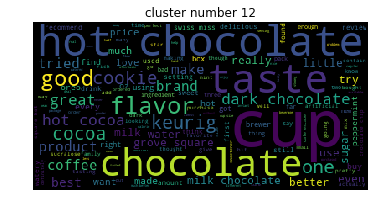

word list for label =  13
890    getting worried read reviews specifically one ...
Name: desc, dtype: object


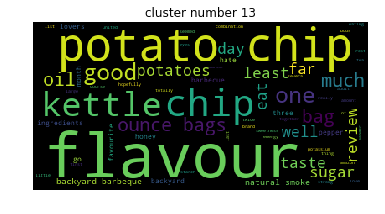

word list for label =  14
5       using food months find excellent fact two dogs...
97      five cats one elderly cat years four year rang...
99      not know science diet referred junk food one h...
195     product high quality rich full flavor delivery...
266     one boys needed lose weight not put food floor...
267     cats happily eating felidae platinum two years...
268     three cats youngest eleven years old another f...
270     canidae felidae also changed formula cats not ...
271     started cat felidae platinum weeks ago loves o...
272     fed cats lot stuff boy cats not picky eaters l...
434     used buy healthy snacks office cafeteria consi...
519     wanted post found small bits plastic food feed...
522     daughter favorite baby food far ones eat rarel...
1233    happy found online reasonable price two dogs l...
1239    please think twice purchasing product especial...
1248    open stuff looks like real food spoon onto dis...
1290    bought dog food bag showed pictured ve

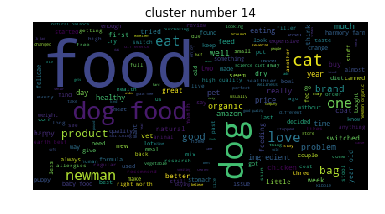

word list for label =  15
8       mix probably not something would want use ever...
9       description product disceptive product represe...
10      bought brand online indian grocery store usual...
11      use keep finicky toddler protein levels great ...
13      company american classic business years best h...
14      love pico pica adds flavor not hot eat least m...
23      used one green ball etc golfer cake made one l...
26      natural ingredients no preservatives say fanta...
27      adzuki azuki beans ment used asian sweets make...
29      not good yummy smell like cloves cooking taste...
30      good stuff like lentils not need soak small fe...
33      go mothers home one day cooked fried chicken r...
34      use stuff pretty much everything turkey sandwi...
43      best years ago used loved moved could not find...
49      without doubt finest sweet chilli sic sauce wo...
55      sauce fine however not resist flagging particu...
65      read nine reviews preceded wondered pr

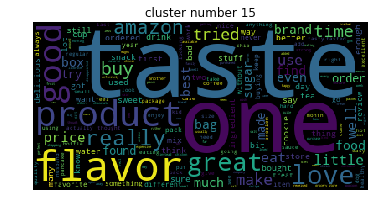

word list for label =  16
286    kit pulls together several standard components...
287    love portable electric corrals fantastic optio...
Name: desc, dtype: object


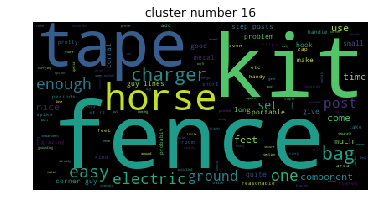

word list for label =  17
1875    yes cubes expensive fact almost gave four star...
Name: desc, dtype: object


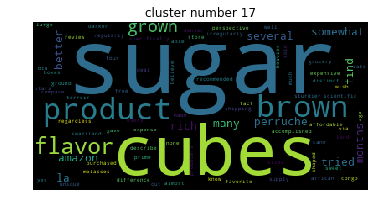

word list for label =  18
770     instead pork rinds oil salt vinegar lactose ma...
905     first discovered kettle chips sea salt vinegar...
2535    pop chips good mission lose weight replaced hi...
2577    despite plethora positive product reviews snac...
2642    lot us constantly watching weight calorie inta...
2692    popchips really really good not expect regular...
2693    straight talk foodie not top chef food critic ...
2755    potato chip addicted not enjoy potato chips al...
2759    little hesitant try especially reading mixed r...
2766    practically falls category healthy snack well ...
2768    sort health nut weened highly palatable junk f...
2796    not get specifics chips listed amazon however ...
2804    love amazon love reviews people introduced alo...
4081    another reviewer stated many reviews product a...
4673    received first ever omaha steaks order receive...
Name: desc, dtype: object


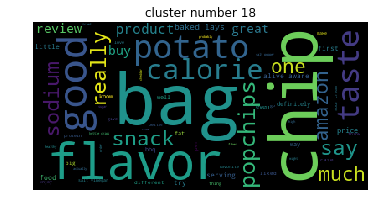

word list for label =  19
85      first drank tea naniboujou lodge north shore m...
104     not much tea drinker bought breville automatic...
105     live digestive problems eat lot mint mint loze...
107     love tea hot cold always looking try new ones ...
125     peach flavored diet tea snapple extremely refr...
172     bought nunaturals white stevia maltodextrin se...
234     sinus buster tea interesting aroma seeping tas...
238     change original post tea husband suffer sinus ...
245     please able get tea amazon pleased service sin...
246     love tea seriously mom suffer bad sinus proble...
265     high hopes ordered tea years ago san francisco...
308     wonderful warm flavored tea especially colder ...
570     zen brews golden amber liquor aroma sweet spea...
1039    first tried tea french restaurant ran usual bl...
1058    really good green tea without bitterness orang...
1059    dynasty brand green tea best green tea ever ta...
1184    let start saying not buy tea diet supp

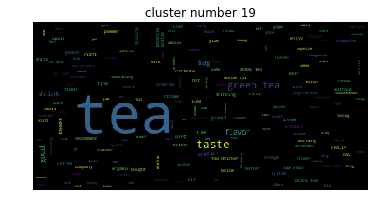

word list for label =  20
3137    n e coconut water splash pineapple drink found...
Name: desc, dtype: object


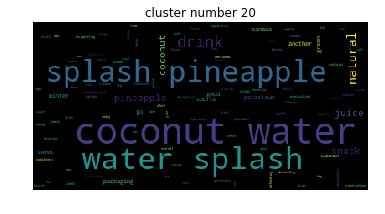

word list for label =  21
4707    organic foods probably important first couple ...
Name: desc, dtype: object


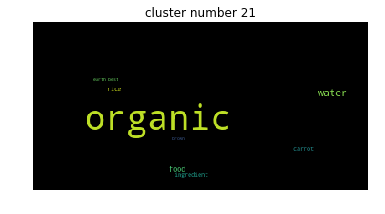

word list for label =  22
2889    must true says package america favorite cake s...
3854    ok bought bisquick gf first thing tried make d...
Name: desc, dtype: object


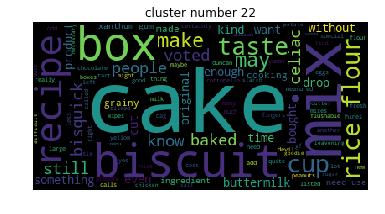

word list for label =  23
335     people watching weight nutrition chips excelle...
338     big fan carbs fat protein balance crisps salt ...
490     crackers great snack no cholestoral use sea sa...
607     good flavor not resemble oreo purchased along ...
627     looking forward order amazon calorie restricte...
667     quite amazon starting retailing food items nea...
771     love salt vinegar potato chips not eat low car...
772     like salt vinegar chips want avoid carbs pork ...
776     best tasting tortilla chips ever become allerg...
780     potato chips delicious not potato chips approx...
781     chips great snack not want junk assiciated chi...
782     love chips flavor not plain sweet spicy time d...
783     thesedo not like hot food might bit much great...
786     first introduced red rice beans chips hometown...
789     husband mexican picky tortilla chips absolutel...
796     received chips gift basket absolutely loved se...
797     love chips ordered florida case chips 

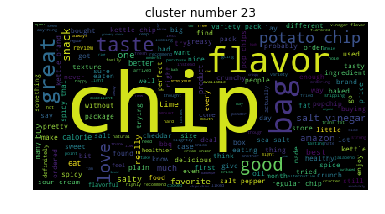

word list for label =  24
1374    bought back january never got around reviewing...
Name: desc, dtype: object


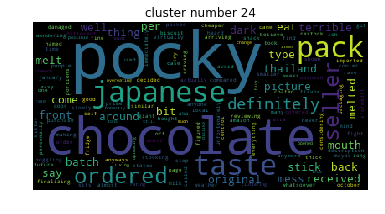

In [105]:
printWordCloud(df,25)

Observation: Cluster 0 : Talks about food and ingerdients, Cluster 1 : Clubs the taste of the food into one category,Cluster 2: Catgorizes coffee related reviews,Cluster 3 : Caterorizes best products reviews

### [5.1.1] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

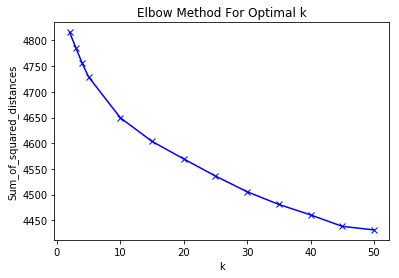

In [106]:
kmeanWithK(final_tf_idf)

In [107]:
kmeans = KMeans(n_clusters=25, random_state=0).fit(final_tf_idf)

In [108]:
newproce_reviews = np.asarray(preprocessed_reviews)
labels = kmeans.labels_
df = pd.DataFrame({'desc':newproce_reviews, 'labels':labels})
df.head()

desc  labels
0  product available victor traps unreal course t...       3
1  used victor fly bait seasons ca not beat great...       3
2  received shipment could hardly wait try produc...       3
3  really good idea final product outstanding use...       3
4  glad cocker standard poodle puppy loves stuff ...      17

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

word list for label =  0
82      though coffee expensive compared regular store...
140     husband took vacation costa rica wonderful tim...
141     coffee delicious full bodied leaves great almo...
143     first tasted coffee hotel coffee shop costa ri...
144     coffee smoothest dark roast coffee ever tasted...
145     forget starbucks peets anything else real deal...
146     husband fell love cafe britt coffee costa rica...
147     love coffee like reviewers took trip costa ric...
148     used use coffee visited costa rica gave aunt t...
283     bought christmas present smells like milk shak...
421     looks fresh clean roasted toaster oven also us...
731     coffee company delivers great coffee taste lik...
756     like strong coffee flavor exceptional not foun...
758     husband always searching better coffee seeming...
759     excellent enjoyed yuban coffee many years rece...
760     yuban makes best cup coffee either roast never...
761     living baton rouge wife drank popular r

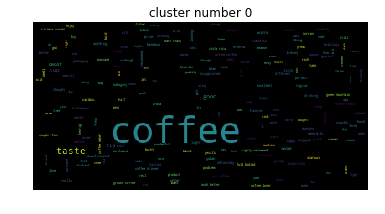

word list for label =  1
257     addicting fantastic snack mix wonderful variet...
945     ordered kettle chips following flavvorssalt fr...
1332    careful ordered pack invoice says pack receive...
2118    mccann instant irish oatmeal variety pack regu...
2122    instant oatmeal become soggy minute water hits...
2536    first tried product get together jelly belly f...
2538    love popchips especially individual portion si...
2541    describe popchip would say hybrid potato chip ...
2542    popchips excellent excellent flavor low calori...
2543    love popchips really treat get variety flavors...
2545    popchips nice alternative potato chips not gre...
2553    expected idk maybe tasteless cardboard really ...
2559    lasted month sampled flavors got eat barbecue ...
2560    great product flavors delicious loved fact sin...
2563    popchips delicious much healthier regular pota...
2566    variety pack popchips r sooo good flavors r de...
2569    love pop chips variety bag great deal e

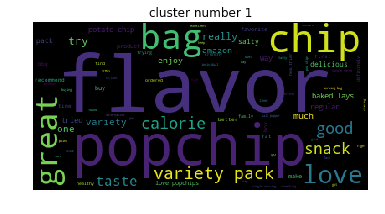

word list for label =  2
151     chocolate covered espresso beans wonderful cho...
263     chocolate coconut lose love ross chocolates re...
567     tried milk chocolate hazelnuts first time rece...
1145    cadbury chocolate uses different formula count...
1146    us made version cadbury chocolate distinct tas...
1189    chocolate cake fantastic reason think would we...
1374    bought back january never got around reviewing...
1497    not gourmet chocolate chip cookie best chocola...
1515    love strawberries dipped chocolate locally cou...
2359    friend favorite candy eight not available anyw...
2814    bake rarely impressed store bought cookies one...
2816    love hot chocolate nice creamy flavor price go...
2944    best caramel chocolate combination ever tasted...
2946    good quality brand chocolate many flavours one...
2947    best chocolate world critic humble opinion mad...
3084    got girlfriend birthday fruit actually tasted ...
3359    holiday liquor cups exactly looking cho

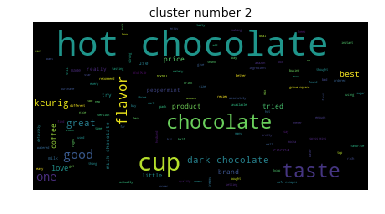

word list for label =  3
0       product available victor traps unreal course t...
1       used victor fly bait seasons ca not beat great...
2       received shipment could hardly wait try produc...
3       really good idea final product outstanding use...
9       description product disceptive product represe...
17      found product search edible gold leaf decided ...
19      used product multiple times fact purchased fou...
21      product allows make really big splashes provid...
77      prefer jerky dry texture always hard time find...
81      delicious candy outstanding price rich product...
86      product gift far distant relative arrived righ...
96      feed hills science diet pet love vet tells hon...
106     good quality product definitely helps tame tum...
108     bought girlfriend tummy issues absolutely love...
134     begun drink penta water unless absolutely necc...
149     product exactly advertised fresh unfortunately...
158     quite skeptical stevia first tried anot

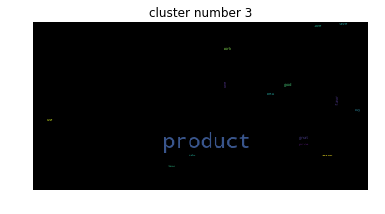

word list for label =  4
133     love water uplifting feel better drinking arse...
381         tasty gluten free option kids loved not spicy
386     tasty easy make need quick filling meal needs ...
455     mrs may pumpkin crunch best bunch like pumpkin...
457     eat gluten free family not pasta far kids not ...
459     celiac daughter loves gluten free animal pasta...
642     baked first batch muffins pleased easy make ta...
644     product comes good company makes number excell...
648     bought local grocery store wish would read rev...
651     folks comparing hodgson blueberry muffin mix o...
654     muffins good made according recipe box changed...
657     family really liked muffins also made vacation...
658     recently discovered sensitivities dairy wheat ...
659     say really wanted like muffins could not reall...
721     product good feeling rather highly priced not ...
725     need gluten free non dairy no egg pickings pre...
1055    served wonderful cake christmas party h

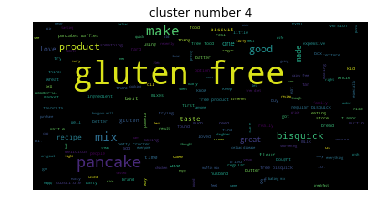

word list for label =  5
490     crackers great snack no cholestoral use sea sa...
771     love salt vinegar potato chips not eat low car...
772     like salt vinegar chips want avoid carbs pork ...
775     nice case chips quite tasty definitely enjoy k...
816     chips delicious like salt pepper flavored chip...
830     salt vinegar chips definitely favorite type po...
834     favorite gluten free dairy free flavored chips...
839     ordering sea salt chips year love daughter pic...
840     strongest tasting salt vinegar chips could sti...
851     buy mostly vending size bag important kettle o...
859     love kettle brand chips love honey dijon years...
861     hands absolute best salt vinegar chips buy gre...
871     love salt vinegar potato chips one choose flav...
873     got sea salt vinegar chips kettle used salt vi...
881     new favorite always fan salt vinegar honey dij...
892     great chips great price odds like fish chips s...
893     really looking forward trying chips sin

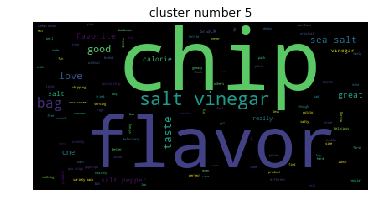

word list for label =  6
90      five minutes one tentacle bitten ball inside c...
186     dog loved think probably helped gas dare say b...
187     year old scottish terrier food allergies no wh...
302     must say vitakraft put life back dog old vitak...
303     dog loves vitakraft dog drops carob much trick...
304     dog loves treats get anything using much cheap...
1241    switched merrick dog food several years ago do...
1242    adopted dalmatian earlier year heard lots caut...
1243    switched merrick whole earth brand pate style ...
1262    shipping really good got ordered time buy alit...
1287    great snack dog food allergies chicken pound s...
1290    bought dog food bag showed pictured veggies ch...
1405    one thing dog likes liver biscotti dog treats ...
1408    portuguese water dog trained bite sized little...
1422    dog loves treats sprinkle regular dry dog food...
1522    new food dog seems adjusted well product thank...
1523    got dog lot research regarding dog food

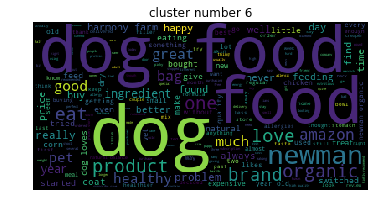

word list for label =  7
128     something eat starving please give real food h...
153     need cut sugar way go love stevia iced tea gre...
156     stevia pretty much natural zero calorie sweete...
157     years using synthetic sweeteners like equal sw...
159     love use sugar substitute everything beverages...
161     discovered product couple years ago really lik...
165     nunaturals stevia sweetener use beverages cook...
168     recently low carb diet find no longer tolerate...
170     looking sweetener delicious tea stevia used sw...
173     hated stevia licorice taste tried nustevia sin...
174     great product stevia powder not raise blood gl...
175     hooked stevia not natural tastes great truly g...
176     first time tried product years ago venetian sp...
177     cutting sugar diet went splenda finding also u...
182     used use agave nectar honey even though picked...
183     nustevia white stevia powder amazing low carb ...
184     tried various brands stevia always come

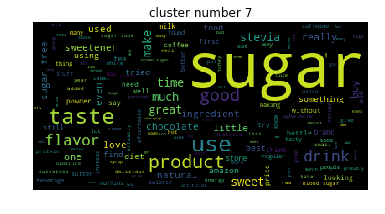

word list for label =  8
327     soy crisps excellent choice snacking grams pro...
336     found co worker delicious low calorie pack pro...
337     wanted give soy crisps justice stars ordering ...
338     big fan carbs fat protein balance crisps salt ...
442     tryed almond crunch delicious healthy snack be...
482     love crackers perfect snack need something sal...
485     not good sesmark savory rice minis available l...
607     good flavor not resemble oreo purchased along ...
667     quite amazon starting retailing food items nea...
674     made according package directions added cup mi...
776     best tasting tortilla chips ever become allerg...
779     tried conventional kettle crinkle chip verson ...
780     potato chips delicious not potato chips approx...
781     chips great snack not want junk assiciated chi...
782     love chips flavor not plain sweet spicy time d...
783     thesedo not like hot food might bit much great...
786     first introduced red rice beans chips h

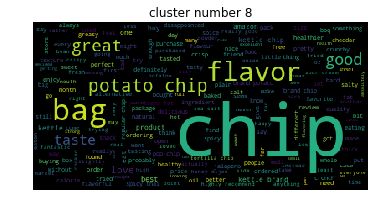

word list for label =  9
83      fallen love tea british tea fanatic ashby supe...
84      packaging cute ashby teas tea exceptional woul...
85      first drank tea naniboujou lodge north shore m...
104     not much tea drinker bought breville automatic...
105     live digestive problems eat lot mint mint loze...
107     love tea hot cold always looking try new ones ...
125     peach flavored diet tea snapple extremely refr...
167     best tasting stevia tried also think better va...
172     bought nunaturals white stevia maltodextrin se...
179     used buy product size health food store florid...
230     tea not anything steal issues itching throat e...
232     love sinus buster tea husband thinks great cle...
233     husband taking sinus buster tea day bedtime mo...
234     sinus buster tea interesting aroma seeping tas...
238     change original post tea husband suffer sinus ...
239     used sinus infection lost voice completely sor...
240     bought tea based upon research done ing

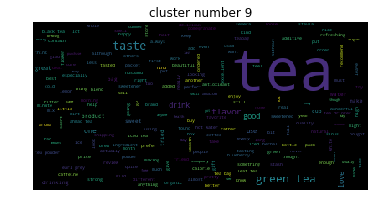

word list for label =  10
15      thank goodness mexgrocer love pico pica sauce ...
16      different sauce nothing like anything find gro...
28      good beans not find grocery stores live ordere...
122     product arrived sanitary seal place good condi...
136     best way cook roast local grocery went buisnes...
142     first tried britt dark roast costa rica lot ri...
154     started using nustevia several years ago back ...
166     tried every brand stevia market hands best use...
171     not like using artificial sweeteners chemicals...
196     bag oatmeal seemed like way much time went fou...
206     formula great works wonders baby spits wtf exp...
210     best tasting cracker ever tasted may cost less...
252     tasted snack local pub found tasty much better...
260     found mix ft myer commissary looked product la...
262     thanks amazon carrying wonderful product local...
281     good price product started baby similac soy fo...
332     recently found allergic wheat milk ima

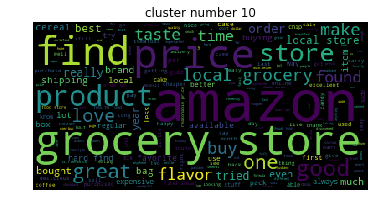

word list for label =  11
10      bought brand online indian grocery store usual...
135     bought bottles stuff purity vpi record washing...
349     substitute nut milk coconut milk goat milk eve...
1186    excellent gf not bad used basis coconut cake p...
3119    usually pineapple coconut drinks drink not tas...
3120    love coconut pineapple not wild one coconut wa...
3121    amy brians coconut water yum vico plain tetra ...
3123    coconut water hint pineapple shipped us indone...
3125    coconut water splash pineapplethis refreshing ...
3126    ride leader bicycle club use coconut water hig...
3127    ugh tried replacement coconut water pineapple ...
3128    got n e coconut water w splash pineapple delic...
3130    tried different brands coconut water n e favor...
3131    admit fully expected dislike product approache...
3132    received single container one coconut water sp...
3133    decided try although not big fan flavored wate...
3137    n e coconut water splash pineapple dri

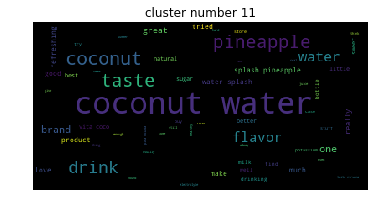

word list for label =  12
164     ordered much success liquid products not bitte...
4013    trying several k cups threw rest box away ever...
4015    hot chocolate k cups not work like coffe k cup...
4019    hot cocoa nastiest tasting instant cocoa ever ...
4020    even kids like always asking hot cocoa not swe...
4025    got new keurig immediately went search forthe ...
4083    use lot raw cocoa power protein drinks high pr...
4084    cocoa powder deep fruity taste highly recommen...
4344    tried number k cup hot chocolates grove square...
4345    feel like tried every hot cocoa k cups think b...
4349    husband really like cocoa add extra milk cup c...
4355    great hot cocoa long read box use setting coff...
4358    good value money good hot cocoa excellent howe...
4359    far best hot cocoa found yet keurig love assor...
4362    excellent product tip keurig people shake k cu...
4363    really like hot cocoa like sooo much cocoa lat...
4367    recieved keurig k cup brewer christmas

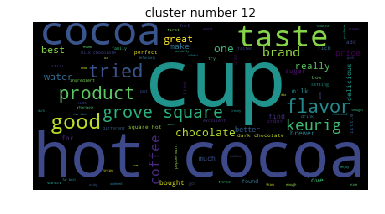

word list for label =  13
26      natural ingredients no preservatives say fanta...
163     stevia best tasting ever tried also mixes beve...
181     favorite stevia product subscribe save queried...
201     nothing good service ever since started orderi...
282     formula life saver old little viral bug made s...
315     excellent customer service quick ship well pac...
362                               excellent quality fresh
742     good snap bite nice honey beef taste choo choo...
752     buffalo bills premium snacksi realize taste in...
753     natural beef soft taste not isnap drier outer ...
757     not able find dark roast yuban stores recently...
774     customer service beyond compare would gladly b...
777     good job shipping order quickly nothing like a...
876     sent week past fresh date stock chips noticeab...
964     looking pictures someone put showing crushed b...
994     reason amazon would not ship alaska sent grand...
1046    found wild thymes many years ago conti

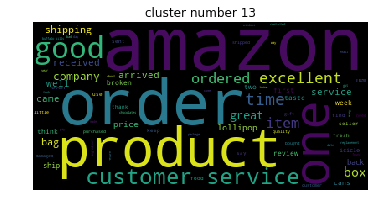

word list for label =  14
22      cute affordable set son golf theme party great...
25      golf set arrived quickly pictured birthday fiv...
88      strong pure need little bit get great flavor h...
109     fennel smells fresh tastes good makes great ad...
112     used pioneer gravy number years easy make tast...
123     soy milk scrumptious variety extra nutrients a...
139     great tasting coffiee one best ever problem hi...
152     ordered coffee themed wedding arrived fight fr...
155     looking healthier alternative splenda equal nu...
208     not great plain wonderful mixed herbs little b...
216     bought gift sister excited see arrived great c...
229     high hopes purchased produce shipping amazingl...
253     taste great gave terrible migraine msg sensiti...
280     great formula son not getting stomach pains li...
284     great temporary fence horses kinda unwieldy ma...
285     not owned portable fence horses impressed liki...
318     cool kit gifts great price kit dave sa

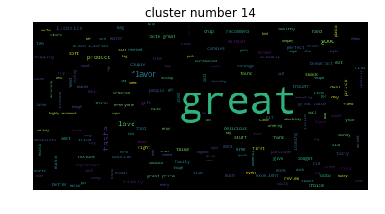

word list for label =  15
14      love pico pica adds flavor not hot eat least m...
29      not good yummy smell like cloves cooking taste...
30      good stuff like lentils not need soak small fe...
76      goes self proclaimed condiment queen nation ke...
89      much white pith orange peel making product ove...
110     think really good deal seal rubbermaid contain...
129     synagogue passover care package candies wow go...
162     love stevia tried many different kinds years o...
287     love portable electric corrals fantastic optio...
321     consistent soy crisps light flavorful always f...
322     bad habit snacking not get rid purchased make ...
341     favorite tea drink year round never get tired ...
356     candy bars might seem like overkill always tel...
359     hate honey love bit honey candy really not tas...
361     not bit honey since kid seeing amazon made pur...
363         glad ordered candy still taste like years ago
376     good sweetsamazon always excellentamaz

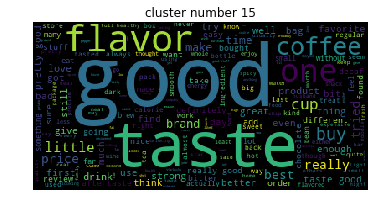

word list for label =  16
34      use stuff pretty much everything turkey sandwi...
42      love stuff put chicken even steaks sweet bit s...
70      delicious makes gourmet cook novice put chicke...
78      family love baci ever since lived europe daugh...
137     love product cant find locally sometimes littl...
209     managed find crackers countries travels run lo...
211     product quick snack light tasteful spread like...
251     agree said great snack wanted say piad pack oz...
261     love eat pasta totally clueless make one saw g...
310     guy love saucethings perfect gift love wooden ...
323     really love snacks low calories fat high prote...
328     love soy crisps perfect salty crunch hard time...
333     one favorite ways eat grains plus good source ...
334     love light crispy salty snacks soy crisps best...
339     huge fan genisoy soy crisps deep sea salted fl...
351     husband loves pudding kind dessert end dinner ...
352     children eat healthy products love gra

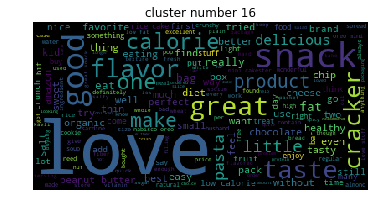

word list for label =  17
4       glad cocker standard poodle puppy loves stuff ...
7       shipped day ordered arrived within days live o...
8       mix probably not something would want use ever...
11      use keep finicky toddler protein levels great ...
12      get busy home like sausage lot quick meal opti...
18      purchased item cake called gold dust never tho...
20      used super gold luster dust create exquisite c...
23      used one green ball etc golfer cake made one l...
24                                                       
27      adzuki azuki beans ment used asian sweets make...
32      not truly spicy year old loves stuff great chi...
43      best years ago used loved moved could not find...
47      stuff good mom gave bottle go eggrolls hooked ...
74      one favorite sauces handy order get two giant ...
79      ordered item large quanity wanted items packag...
80      returned italy told little chocolates favs ita...
91      scotties full hot spots used within we

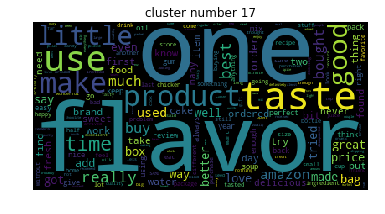

word list for label =  18
5       using food months find excellent fact two dogs...
6       nine cats crazy kibbles last thing want cat fo...
95      review make sound really stupid whatever not r...
97      five cats one elderly cat years four year rang...
98      aged cat sensitive stomach cannot eat cat food...
99      not know science diet referred junk food one h...
100     although seems like great product definitely n...
101     made mistake believing science diet best choic...
102                 perfect food cat fact one eat wet dry
266     one boys needed lose weight not put food floor...
267     cats happily eating felidae platinum two years...
268     three cats youngest eleven years old another f...
269     much good thing worked kibble time slowly shif...
270     canidae felidae also changed formula cats not ...
271     started cat felidae platinum weeks ago loves o...
272     fed cats lot stuff boy cats not picky eaters l...
434     used buy healthy snacks office cafeter

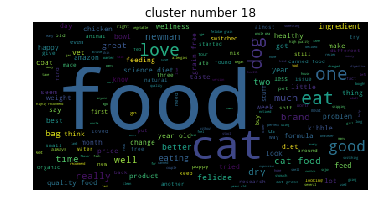

word list for label =  19
111     nothing easier nothing better even beats grand...
113     not south live sofla sometimes get southern in...
114     gravy mix excellent except not use water calle...
248     small night club hand popular snack item first...
249     received whole package delicious tasty perfect...
250     definitely best snack mix ever got buddies man...
256     mix great anytime love would recommend anyone ...
259      absolutely love mix keep home bar everyone loves
538     daughter loved stuff natural made well good mi...
652     really excited surprised found mix local wal m...
656     concur previous reviewers muffins bitter taste...
660     really wanted taste good something bitter add ...
683     recently purchased bread machine tried potato ...
1054    growing mother always made apple sauce cake ev...
1061    using spice mix many years found hard find lat...
1069    wonderful mix spices one favorite uses chicken...
1115    not know anything chutney went known r

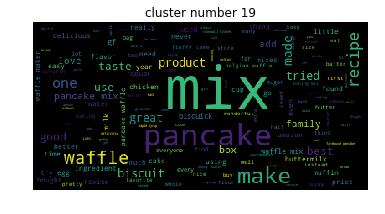

word list for label =  20
330     love flavor soy crisps deep sea salted however...
3478    baby white popcorn wabash farms pops nicely no...
3479    made whirley pop really lighter crisper larger...
3480    liked idea small popcorn pops really well popp...
3481    bought popcorn based reviews hulls softer baby...
3482    popcorn good cant believe difference popcorn r...
3483    not spend money product find popping ratio ext...
3484    terrible popcorn no taste poor popping ratio s...
3485    popcorn really great enjoy taste smallness act...
3486    bought whirley pop stovetop popcorn popper sev...
3487    popcorn grear color white taste average due sh...
3488    enjoyed popcorn every bit much not movie theat...
3489    use olive oil cook salt well best tender popco...
3490    ordered bags free shipping reviews really like...
3491    doctor told must eat hulless popcorn popcorn n...
3492    popcorn yummy warned trouble popping using air...
3495    great popcorn good popping results won

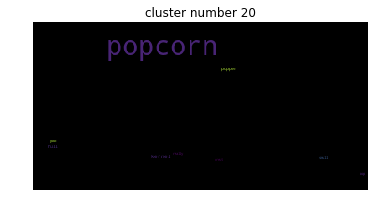

word list for label =  21
115     awesome little snack treat favorite pup dog tw...
116     treats ok main complaint small size lifesaver ...
117     charlee bears small low calorie use en masse t...
118     love treats two german shepherds think treats ...
120     hit pups price calories piece not beat great t...
189     went searching charcoal dog biscuits reading h...
190     food drug administration fda cautioning consum...
294     found local pet store could not locate great p...
295     bought product dogs accidents laundry room ove...
298     smell good tempted try keep real chocolate loc...
299              dogs dogs like spoil love special treats
305     superior dog treat chocolate flavor drops not ...
743     like product much honey flavor makes taste goo...
1229    first started use iams savory sauce dogs loved...
1233    happy found online reasonable price two dogs l...
1234    feeding dogs year past months problem cases gr...
1237    canned food real chunks chicken dogs l

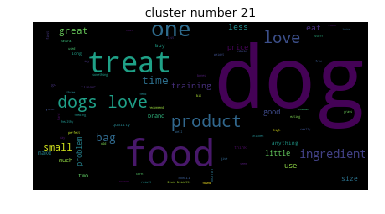

word list for label =  22
127     buy cookies not regret hands best store bought...
198     better organic oats advertised elsewhere takes...
212     cookies big hit progressive new year eve dinne...
214     primary reason ordering picture shown cookies ...
215     expecting cookies going normal size wrong plan...
217     ordered fortune cookies rewards students time ...
218     reading earlier reviews genuine chinese fortun...
219     cookies kind stail fast shipping good packing ...
220     second time ordered product happy enough first...
221     well packed broken understandable cookies tast...
223     brought cookies dish pass family christmas get...
224     daughter kindergarten class celebrated chinese...
225     fortune cookies shipped immediately packed wel...
274     used types baking including cakes biscuits coo...
571     chips ahoy cookies not tasty children husband ...
573     not usually like really crispy cookies taste c...
574     good cookies really delicious satisfyi

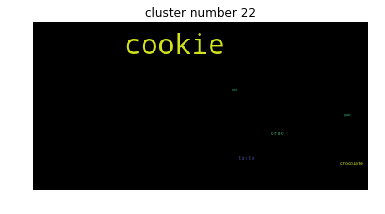

word list for label =  23
13      company american classic business years best h...
31      sauce something permanent staple table everyth...
33      go mothers home one day cooked fried chicken r...
35      first tasted sauce visiting alaska served fish...
36      sooo good followed advice thought outside conv...
37      ever wondered delicious dipping sauce crab won...
38      kids love sauce many things great rice chicken...
39      looking good sweet sour sauce chicken based re...
40      mae ploy sweet chili sauce becoming standard c...
41      not purchase product amazon purchased oz bottl...
44      great multi use sauce great using baste grilli...
45      sauce excellent blend sweet spicy love eggroll...
46      tried sauce first favorite place eat happy abl...
48      mae ploy sweet chili sauce best use instead du...
49      without doubt finest sweet chilli sic sauce wo...
50      not mean asian sauces easily best sauce ever p...
51      use banquet kitchen many dishes perfec

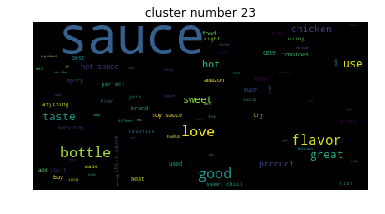

word list for label =  24
103     comes case bought one locally ordering large a...
130     became addicted eating first time tasted years...
191     not eat oats funny taste kids also think taste...
205     purchased son give baby boy born make nice ann...
228     bought tea major sinus infection crisis includ...
276     decided try formula baby since started gassy h...
278     newborn cries inconsolably try lactose free fo...
279     really want feeding baby bottle corn syrup use...
292     bought sister christmas loved afraid would eat...
306     puppy megabyte picky puppy spending hundreds d...
325     bought decided wanted eat even snack healthier...
385     simply not like easy prepare eat feel eatting ...
388     tried love thai food ginger coconut problem me...
389     bought son take work lunch apparently co worke...
432     ok not speak last review written looks like lo...
446     typical americans know eat better often not he...
448     used like product learned made china m

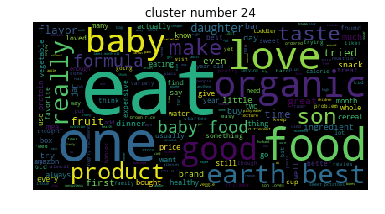

In [109]:
printWordCloud(df,25)

Observation: Label 0 : Coffee related reviews,label1 = Chips ad its taste,cluster 21: Taste of food related.Cluster 24 : Baby food related reviews.

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

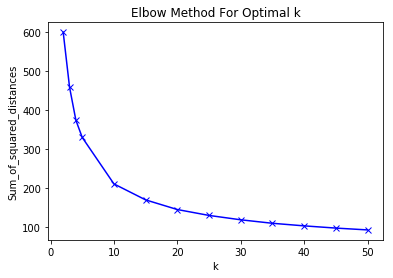

In [110]:
kmeanWithK(sent_vectors)

In [111]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(sent_vectors)

In [112]:
newproce_reviews = np.asarray(preprocessed_reviews)
labels = kmeans.labels_
df = pd.DataFrame({'desc':newproce_reviews, 'labels':labels})
df.head()

desc  labels
0  product available victor traps unreal course t...       6
1  used victor fly bait seasons ca not beat great...       7
2  received shipment could hardly wait try produc...       2
3  really good idea final product outstanding use...       2
4  glad cocker standard poodle puppy loves stuff ...       2

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

word list for label =  0
38      kids love sauce many things great rice chicken...
39      looking good sweet sour sauce chicken based re...
42      love stuff put chicken even steaks sweet bit s...
45      sauce excellent blend sweet spicy love eggroll...
46      tried sauce first favorite place eat happy abl...
114     gravy mix excellent except not use water calle...
130     became addicted eating first time tasted years...
153     need cut sugar way go love stevia iced tea gre...
161     discovered product couple years ago really lik...
164     ordered much success liquid products not bitte...
169     trying get sugar product great sweet taste wit...
185     nice productfull quality items not cheap candi...
299              dogs dogs like spoil love special treats
316     son loved sauces sauce way hot insanity sauce ...
333     one favorite ways eat grains plus good source ...
363         glad ordered candy still taste like years ago
379     ordered pack ate quickly husband like t

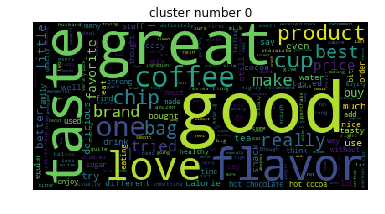

word list for label =  1
7       shipped day ordered arrived within days live o...
9       description product disceptive product represe...
19      used product multiple times fact purchased fou...
23      used one green ball etc golfer cake made one l...
26      natural ingredients no preservatives say fanta...
31      sauce something permanent staple table everyth...
37      ever wondered delicious dipping sauce crab won...
50      not mean asian sauces easily best sauce ever p...
56      really great sauce slightly expensive stores g...
59      use meats fish poultry vegies purpose dip et a...
65      read nine reviews preceded wondered product de...
70      delicious makes gourmet cook novice put chicke...
74      one favorite sauces handy order get two giant ...
80      returned italy told little chocolates favs ita...
81      delicious candy outstanding price rich product...
82      though coffee expensive compared regular store...
90      five minutes one tentacle bitten ball i

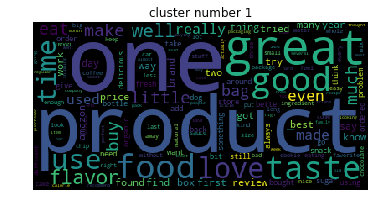

word list for label =  2
2       received shipment could hardly wait try produc...
3       really good idea final product outstanding use...
4       glad cocker standard poodle puppy loves stuff ...
20      used super gold luster dust create exquisite c...
21      product allows make really big splashes provid...
22      cute affordable set son golf theme party great...
25      golf set arrived quickly pictured birthday fiv...
36      sooo good followed advice thought outside conv...
40      mae ploy sweet chili sauce becoming standard c...
78      family love baci ever since lived europe daugh...
93      exactly ordered no fuss no muss arrived time p...
97      five cats one elderly cat years four year rang...
117     charlee bears small low calorie use en masse t...
129     synagogue passover care package candies wow go...
152     ordered coffee themed wedding arrived fight fr...
190     food drug administration fda cautioning consum...
197     honeyville rolled oats delicious produc

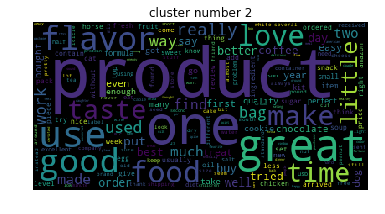

word list for label =  3
381         tasty gluten free option kids loved not spicy
386     tasty easy make need quick filling meal needs ...
641     wheat free natural ingredients easy chew dry g...
644     product comes good company makes number excell...
648     bought local grocery store wish would read rev...
721     product good feeling rather highly priced not ...
834     favorite gluten free dairy free flavored chips...
903        salt free product purchased chips quite greasy
1099    looking great gluten free snack not sorry chos...
1127    licorice good taste daughter gluten free diet ...
1129    gluten free foods tend extremely expensive com...
1185    family favorite brand wheat free gluten free c...
1485    son gluten free not fun tasty free great puthi...
1648        using product year goldie dog loves years old
1943    dog loves loves dog food say love twice dog fo...
1959    please ignore one star comments check bag main...
2096    appreciate fact buy product online free

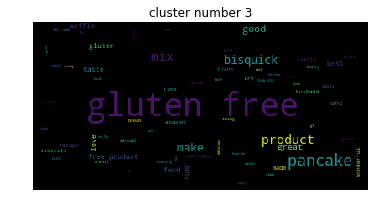

word list for label =  4
24      
121     
456     
601     
718     
792     
1042    
1136    
1183    
1272    
1781    
1816    
2023    
2107    
2353    
Name: desc, dtype: object
Word cloud is not supported for label :  4
word list for label =  5
14      love pico pica adds flavor not hot eat least m...
52      love sauce sweet hot use checken wings instead...
62      sauce good anything cook grill use dip veggies...
75      best sweet chili sauce found anywhere say swee...
83      fallen love tea british tea fanatic ashby supe...
84      packaging cute ashby teas tea exceptional woul...
88      strong pure need little bit get great flavor h...
89      much white pith orange peel making product ove...
91      scotties full hot spots used within week hot s...
144     coffee smoothest dark roast coffee ever tasted...
150     delicious chocolate excellent espresso bean pe...
151     chocolate covered espresso beans wonderful cho...
159     love use sugar substitute everything bever

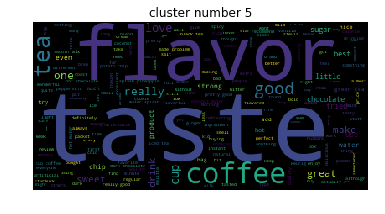

word list for label =  6
0       product available victor traps unreal course t...
6       nine cats crazy kibbles last thing want cat fo...
15      thank goodness mexgrocer love pico pica sauce ...
16      different sauce nothing like anything find gro...
17      found product search edible gold leaf decided ...
79      ordered item large quanity wanted items packag...
94      dried berries still texture quintessential aro...
101     made mistake believing science diet best choic...
124     ordered product send friend husband moved alab...
138     always pleasure find french products web marke...
166     tried every brand stevia market hands best use...
181     favorite stevia product subscribe save queried...
192     good quality oats package came time oats worke...
195     product high quality rich full flavor delivery...
204     ordered amazon fulfilled associate normal amaz...
216     bought gift sister excited see arrived great c...
262     thanks amazon carrying wonderful produc

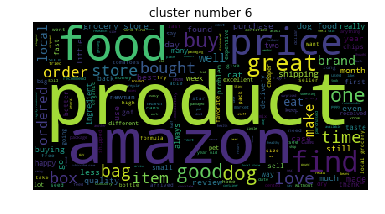

word list for label =  7
1       used victor fly bait seasons ca not beat great...
10      bought brand online indian grocery store usual...
18      purchased item cake called gold dust never tho...
35      first tasted sauce visiting alaska served fish...
41      not purchase product amazon purchased oz bottl...
55      sauce fine however not resist flagging particu...
67      mentioned give try instant party food frozen m...
77      prefer jerky dry texture always hard time find...
98      aged cat sensitive stomach cannot eat cat food...
103     comes case bought one locally ordering large a...
116     treats ok main complaint small size lifesaver ...
122     product arrived sanitary seal place good condi...
123     soy milk scrumptious variety extra nutrients a...
134     begun drink penta water unless absolutely necc...
142     first tried britt dark roast costa rica lot ri...
158     quite skeptical stevia first tried another bra...
163     stevia best tasting ever tried also mix

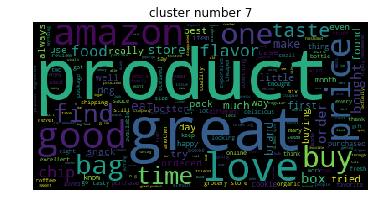

word list for label =  8
11      use keep finicky toddler protein levels great ...
12      get busy home like sausage lot quick meal opti...
27      adzuki azuki beans ment used asian sweets make...
34      use stuff pretty much everything turkey sandwi...
48      mae ploy sweet chili sauce best use instead du...
51      use banquet kitchen many dishes perfect blend ...
54      want spicy different flavor sometimes lightly ...
60      tiny consolation easy thai barbecued chicken c...
61      plenty times eat came mae ploy sweet chili sau...
64      purchased sauce exact sauce used hot sauce bar...
66      introduced sauce good friend mine cambodia run...
69      brought dipping sauce dumplings egg rolls made...
73      love asian flavor w extreme heat sauce w wings...
104     not much tea drinker bought breville automatic...
105     live digestive problems eat lot mint mint loze...
107     love tea hot cold always looking try new ones ...
109     fennel smells fresh tastes good makes g

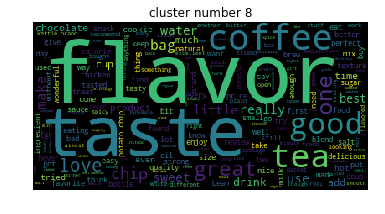

word list for label =  9
28      good beans not find grocery stores live ordere...
136     best way cook roast local grocery went buisnes...
137     love product cant find locally sometimes littl...
194     happy quality product price like reviewer woul...
196     bag oatmeal seemed like way much time went fou...
206     formula great works wonders baby spits wtf exp...
210     best tasting cracker ever tasted may cost less...
255     enjoyed product also provided fast shipping ne...
294     found local pet store could not locate great p...
304     dog loves treats get anything using much cheap...
329     stores not carrying product thank goodness sti...
335     people watching weight nutrition chips excelle...
352     children eat healthy products love graham crac...
366     neighbor love candy difficult find oz packets ...
368     best bit honey ever eaten always bought produc...
439     husband diabetes watch eats great healthy trea...
462     really delicious not something find loc

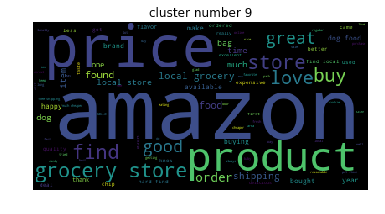

word list for label =  10
8       mix probably not something would want use ever...
13      company american classic business years best h...
32      not truly spicy year old loves stuff great chi...
33      go mothers home one day cooked fried chicken r...
43      best years ago used loved moved could not find...
44      great multi use sauce great using baste grilli...
47      stuff good mom gave bottle go eggrolls hooked ...
49      without doubt finest sweet chilli sic sauce wo...
58      made crab rangoon used sauce dipping sauce gre...
63      whole family loves sauce use primarily recreat...
68      like product unique taste enough spiciness swe...
72      cook lot chinese dishes household sweet chili ...
76      goes self proclaimed condiment queen nation ke...
85      first drank tea naniboujou lodge north shore m...
87      not know cactus tequila unique combination ing...
92      tried found salty plus ate fish sauce fish rea...
112     used pioneer gravy number years easy m

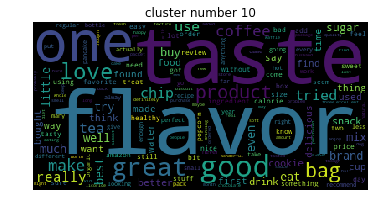

word list for label =  11
30      good stuff like lentils not need soak small fe...
338     big fan carbs fat protein balance crisps salt ...
380     quick easy portable think tastes great favorit...
441     family love almond crunch sweet enough crunchy...
442     tryed almond crunch delicious healthy snack be...
477     things addicting low calories fat love wasabi ...
485     not good sesmark savory rice minis available l...
490     crackers great snack no cholestoral use sea sa...
574     good cookies really delicious satisfying reall...
575          craving sweet not not much bar perfect yummy
674     made according package directions added cup mi...
680     used extra yeast little water came light heard...
701     without question best diet crackers ever witho...
719     ok like sweet potato ones better good fiber co...
772     like salt vinegar chips want avoid carbs pork ...
773     would rated stars vinegar taste overall not ba...
775     nice case chips quite tasty definitely

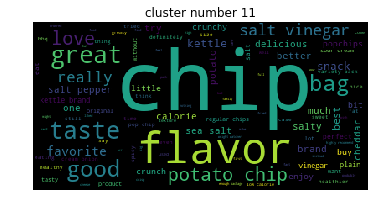

word list for label =  12
57      using sauce years amazing use everything sprin...
86      product gift far distant relative arrived righ...
99      not know science diet referred junk food one h...
132     purchase including free shpping straight penta...
133     love water uplifting feel better drinking arse...
186     dog loved think probably helped gas dare say b...
187     year old scottish terrier food allergies no wh...
267     cats happily eating felidae platinum two years...
270     canidae felidae also changed formula cats not ...
271     started cat felidae platinum weeks ago loves o...
273     really choice comes soy dairy free baking unle...
278     newborn cries inconsolably try lactose free fo...
302     must say vitakraft put life back dog old vitak...
400     also routine baking ingredient put bread along...
403     funny bought flax seed make neck warmer made s...
455     mrs may pumpkin crunch best bunch like pumpkin...
459     celiac daughter loves gluten free anim

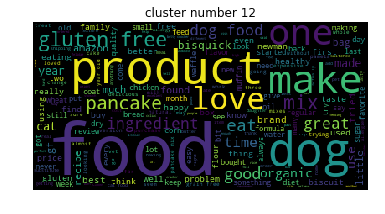

word list for label =  13
29      not good yummy smell like cloves cooking taste...
53      sauce good tastes not hot enough brands tht sl...
392     really like soup mild not like anything hot ri...
606     really like light airy almost like chips inste...
765     say great coffee never tried recently like bet...
793     not like potatoe chips hot sweet overwhelming ...
938     love sour food one not bear strong sour taste ...
1058    really good green tea without bitterness orang...
1424    love licorice get licorice flavor not sugar fl...
1427          real licorice soft great taste healthy love
1510    really great tasting cookies like combination ...
1541    looking nice strong rose tea one tried number ...
1766    super tasty super delicious best tea ever swee...
1772    quick convenient way drink green tea add lemon...
1777    love ease green natural tea anywhear time tast...
1780    saw mint iced tea powder website thought would...
1811    good flavor not real sweet add little 

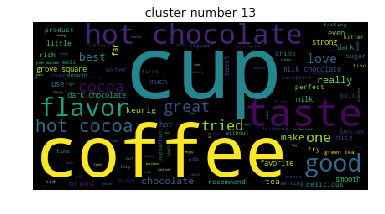

word list for label =  14
5       using food months find excellent fact two dogs...
71      best sauce market use almost food product espe...
102                 perfect food cat fact one eat wet dry
139     great tasting coffiee one best ever problem hi...
154     started using nustevia several years ago back ...
201     nothing good service ever since started orderi...
207     used bbq sauce good especially considering fre...
220     second time ordered product happy enough first...
259      absolutely love mix keep home bar everyone loves
274     used types baking including cakes biscuits coo...
276     decided try formula baby since started gassy h...
296     pug absolutely adores treats anything one get ...
331     thing use buy stores less great taste great pa...
362                               excellent quality fresh
376     good sweetsamazon always excellentamazon alway...
384                    liked much ordered keepre ordering
457     eat gluten free family not pasta far k

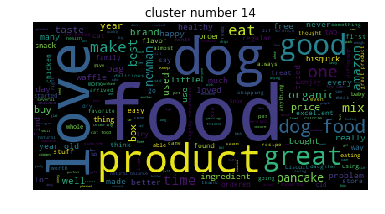

In [113]:
printWordCloud(df,15)

Observation: Cluster 1 : Categorized related to taste,cluster 3 categorized related to bakery items

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

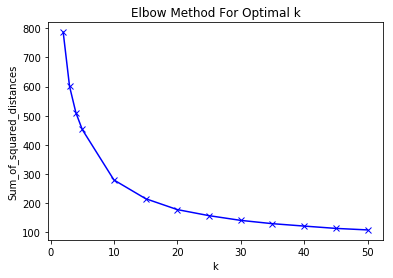

In [114]:
kmeanWithK(tfidf_sent_vectors)


In [115]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(tfidf_sent_vectors)

In [116]:
newproce_reviews = np.asarray(preprocessed_reviews)
labels = kmeans.labels_
df = pd.DataFrame({'desc':newproce_reviews, 'labels':labels})
df.head()

desc  labels
0  product available victor traps unreal course t...      10
1  used victor fly bait seasons ca not beat great...      14
2  received shipment could hardly wait try produc...       5
3  really good idea final product outstanding use...       5
4  glad cocker standard poodle puppy loves stuff ...      10

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

word list for label =  0
9       description product disceptive product represe...
23      used one green ball etc golfer cake made one l...
26      natural ingredients no preservatives say fanta...
37      ever wondered delicious dipping sauce crab won...
43      best years ago used loved moved could not find...
44      great multi use sauce great using baste grilli...
47      stuff good mom gave bottle go eggrolls hooked ...
50      not mean asian sauces easily best sauce ever p...
57      using sauce years amazing use everything sprin...
65      read nine reviews preceded wondered product de...
66      introduced sauce good friend mine cambodia run...
68      like product unique taste enough spiciness swe...
70      delicious makes gourmet cook novice put chicke...
72      cook lot chinese dishes household sweet chili ...
76      goes self proclaimed condiment queen nation ke...
77      prefer jerky dry texture always hard time find...
80      returned italy told little chocolates f

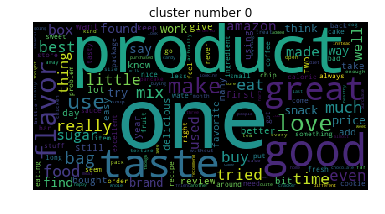

word list for label =  1
29      not good yummy smell like cloves cooking taste...
75      best sweet chili sauce found anywhere say swee...
84      packaging cute ashby teas tea exceptional woul...
88      strong pure need little bit get great flavor h...
104     not much tea drinker bought breville automatic...
127     buy cookies not regret hands best store bought...
144     coffee smoothest dark roast coffee ever tasted...
151     chocolate covered espresso beans wonderful cho...
173     hated stevia licorice taste tried nustevia sin...
182     used use agave nectar honey even though picked...
238     change original post tea husband suffer sinus ...
349     substitute nut milk coconut milk goat milk eve...
567     tried milk chocolate hazelnuts first time rece...
600     dude things pretty good long not bent like ore...
606     really like light airy almost like chips inste...
731     coffee company delivers great coffee taste lik...
759     excellent enjoyed yuban coffee many yea

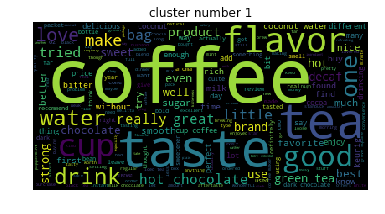

word list for label =  2
24                                                       
121                                                      
456                                                      
601                                                      
718                                                      
792                                                      
820     like plockysthey like us plockys plockys mean ...
1042                                                     
1136                                                     
1183                                                     
1272                                                     
1781                                                     
1816                                                     
2023                                                     
2107                                                     
2353                                                     
Name: desc, dtype: object
Word cloud is not sup

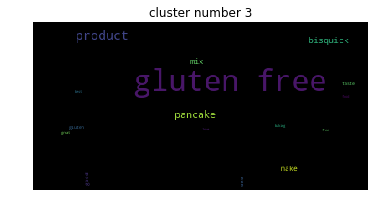

word list for label =  4
5       using food months find excellent fact two dogs...
18      purchased item cake called gold dust never tho...
35      first tasted sauce visiting alaska served fish...
55      sauce fine however not resist flagging particu...
63      whole family loves sauce use primarily recreat...
67      mentioned give try instant party food frozen m...
95      review make sound really stupid whatever not r...
98      aged cat sensitive stomach cannot eat cat food...
102                 perfect food cat fact one eat wet dry
103     comes case bought one locally ordering large a...
116     treats ok main complaint small size lifesaver ...
118     love treats two german shepherds think treats ...
123     soy milk scrumptious variety extra nutrients a...
134     begun drink penta water unless absolutely necc...
142     first tried britt dark roast costa rica lot ri...
154     started using nustevia several years ago back ...
165     nunaturals stevia sweetener use beverag

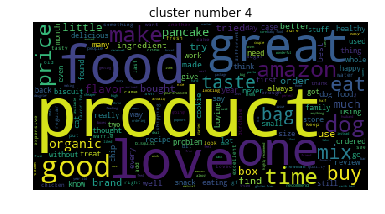

word list for label =  5
2       received shipment could hardly wait try produc...
3       really good idea final product outstanding use...
7       shipped day ordered arrived within days live o...
20      used super gold luster dust create exquisite c...
21      product allows make really big splashes provid...
22      cute affordable set son golf theme party great...
36      sooo good followed advice thought outside conv...
40      mae ploy sweet chili sauce becoming standard c...
78      family love baci ever since lived europe daugh...
93      exactly ordered no fuss no muss arrived time p...
94      dried berries still texture quintessential aro...
97      five cats one elderly cat years four year rang...
124     ordered product send friend husband moved alab...
129     synagogue passover care package candies wow go...
141     coffee delicious full bodied leaves great almo...
145     forget starbucks peets anything else real deal...
152     ordered coffee themed wedding arrived f

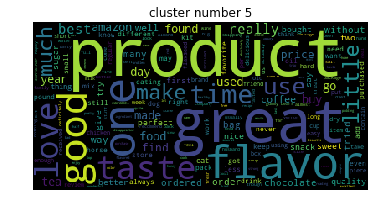

word list for label =  6
338     big fan carbs fat protein balance crisps salt ...
485     not good sesmark savory rice minis available l...
490     crackers great snack no cholestoral use sea sa...
674     made according package directions added cup mi...
701     without question best diet crackers ever witho...
719     ok like sweet potato ones better good fiber co...
772     like salt vinegar chips want avoid carbs pork ...
775     nice case chips quite tasty definitely enjoy k...
776     best tasting tortilla chips ever become allerg...
780     potato chips delicious not potato chips approx...
781     chips great snack not want junk assiciated chi...
783     thesedo not like hot food might bit much great...
788     chips salty hint sweet crisp crunchy best chip...
803     love chips not even like black beans tasty yum...
816     chips delicious like salt pepper flavored chip...
818     best chips ever eaten everyone family loves sw...
830     salt vinegar chips definitely favorite 

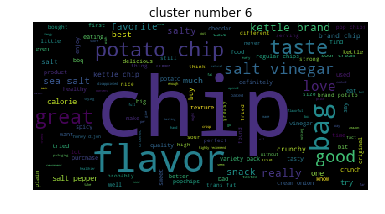

word list for label =  7
304     dog loves treats get anything using much cheap...
381         tasty gluten free option kids loved not spicy
386     tasty easy make need quick filling meal needs ...
481     rice crackers truly delicious w cheese peanut ...
484     excellent product non gluten diet good alone s...
508     year old loves great snack tried find stores n...
519     wanted post found small bits plastic food feed...
613     good great price fast free shipping purchase e...
641     wheat free natural ingredients easy chew dry g...
642     baked first batch muffins pleased easy make ta...
648     bought local grocery store wish would read rev...
658     recently discovered sensitivities dairy wheat ...
721     product good feeling rather highly priced not ...
834     favorite gluten free dairy free flavored chips...
903        salt free product purchased chips quite greasy
1099    looking great gluten free snack not sorry chos...
1127    licorice good taste daughter gluten fre

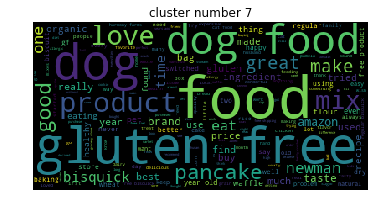

word list for label =  8
8       mix probably not something would want use ever...
10      bought brand online indian grocery store usual...
14      love pico pica adds flavor not hot eat least m...
30      good stuff like lentils not need soak small fe...
32      not truly spicy year old loves stuff great chi...
33      go mothers home one day cooked fried chicken r...
39      looking good sweet sour sauce chicken based re...
49      without doubt finest sweet chilli sic sauce wo...
56      really great sauce slightly expensive stores g...
58      made crab rangoon used sauce dipping sauce gre...
60      tiny consolation easy thai barbecued chicken c...
62      sauce good anything cook grill use dip veggies...
64      purchased sauce exact sauce used hot sauce bar...
87      not know cactus tequila unique combination ing...
92      tried found salty plus ate fish sauce fish rea...
112     used pioneer gravy number years easy make tast...
114     gravy mix excellent except not use wate

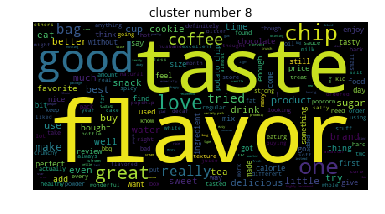

word list for label =  9
13      company american classic business years best h...
38      kids love sauce many things great rice chicken...
41      not purchase product amazon purchased oz bottl...
42      love stuff put chicken even steaks sweet bit s...
45      sauce excellent blend sweet spicy love eggroll...
46      tried sauce first favorite place eat happy abl...
53      sauce good tastes not hot enough brands tht sl...
71      best sauce market use almost food product espe...
130     became addicted eating first time tasted years...
139     great tasting coffiee one best ever problem hi...
153     need cut sugar way go love stevia iced tea gre...
169     trying get sugar product great sweet taste wit...
201     nothing good service ever since started orderi...
220     second time ordered product happy enough first...
259      absolutely love mix keep home bar everyone loves
296     pug absolutely adores treats anything one get ...
299              dogs dogs like spoil love spec

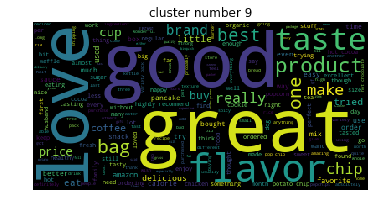

word list for label =  10
0       product available victor traps unreal course t...
4       glad cocker standard poodle puppy loves stuff ...
11      use keep finicky toddler protein levels great ...
12      get busy home like sausage lot quick meal opti...
15      thank goodness mexgrocer love pico pica sauce ...
16      different sauce nothing like anything find gro...
17      found product search edible gold leaf decided ...
19      used product multiple times fact purchased fou...
25      golf set arrived quickly pictured birthday fiv...
27      adzuki azuki beans ment used asian sweets make...
31      sauce something permanent staple table everyth...
34      use stuff pretty much everything turkey sandwi...
59      use meats fish poultry vegies purpose dip et a...
61      plenty times eat came mae ploy sweet chili sau...
69      brought dipping sauce dumplings egg rolls made...
74      one favorite sauces handy order get two giant ...
81      delicious candy outstanding price rich

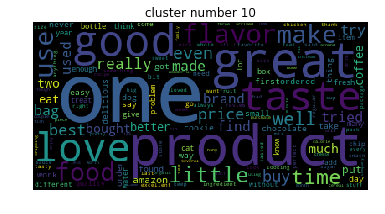

word list for label =  11
85      first drank tea naniboujou lodge north shore m...
1058    really good green tea without bitterness orang...
1196    like green tea brews minutes max not stew tea ...
1313    tea decaffeinated flavor removed lousy tea cas...
1341    tea best tea ever first tasted norway find sta...
1497    not gourmet chocolate chip cookie best chocola...
1510    really great tasting cookies like combination ...
1535    hard rate tea good tea tea nonetheless however...
1777    love ease green natural tea anywhear time tast...
1780    saw mint iced tea powder website thought would...
1802    quick easy way make green tea not sweet barest...
1823    love green tea impressed green tea powder inst...
1829    used always go jamba juice match green tea sho...
1836    looking mint green tea could carry mix want pr...
2086    first time bought tea amazon used get directly...
2161    ahmad tea excellent looseleaf tea eith hot mak...
2185    kind tea not good taste smell wear not

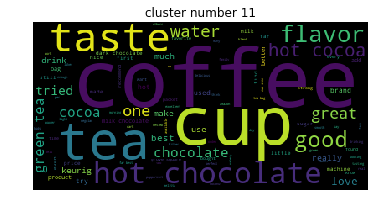

word list for label =  12
48      mae ploy sweet chili sauce best use instead du...
51      use banquet kitchen many dishes perfect blend ...
52      love sauce sweet hot use checken wings instead...
54      want spicy different flavor sometimes lightly ...
73      love asian flavor w extreme heat sauce w wings...
82      though coffee expensive compared regular store...
83      fallen love tea british tea fanatic ashby supe...
89      much white pith orange peel making product ove...
91      scotties full hot spots used within week hot s...
105     live digestive problems eat lot mint mint loze...
107     love tea hot cold always looking try new ones ...
110     think really good deal seal rubbermaid contain...
125     peach flavored diet tea snapple extremely refr...
135     bought bottles stuff purity vpi record washing...
143     first tasted coffee hotel coffee shop costa ri...
148     used use coffee visited costa rica gave aunt t...
150     delicious chocolate excellent espresso

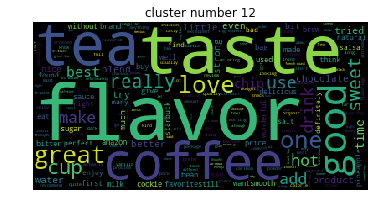

word list for label =  13
28      good beans not find grocery stores live ordere...
136     best way cook roast local grocery went buisnes...
137     love product cant find locally sometimes littl...
158     quite skeptical stevia first tried another bra...
194     happy quality product price like reviewer woul...
196     bag oatmeal seemed like way much time went fou...
206     formula great works wonders baby spits wtf exp...
207     used bbq sauce good especially considering fre...
294     found local pet store could not locate great p...
329     stores not carrying product thank goodness sti...
335     people watching weight nutrition chips excelle...
343     wait cereal go sale buy sale price usually per...
366     neighbor love candy difficult find oz packets ...
368     best bit honey ever eaten always bought produc...
439     husband diabetes watch eats great healthy trea...
462     really delicious not something find local groc...
483     got pack local grocery store tasted fi

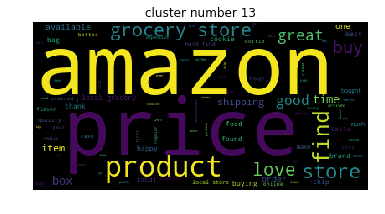

word list for label =  14
1       used victor fly bait seasons ca not beat great...
6       nine cats crazy kibbles last thing want cat fo...
79      ordered item large quanity wanted items packag...
90      five minutes one tentacle bitten ball inside c...
99      not know science diet referred junk food one h...
126     received box great anticipation since not sell...
132     purchase including free shpping straight penta...
138     always pleasure find french products web marke...
166     tried every brand stevia market hands best use...
193     product fresh good not getting complaints anym...
195     product high quality rich full flavor delivery...
204     ordered amazon fulfilled associate normal amaz...
210     best tasting cracker ever tasted may cost less...
260     found mix ft myer commissary looked product la...
262     thanks amazon carrying wonderful product local...
266     one boys needed lose weight not put food floor...
267     cats happily eating felidae platinum t

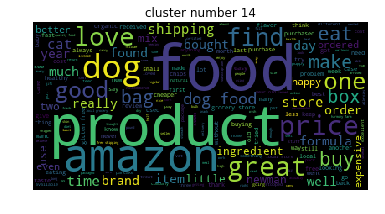

In [117]:
printWordCloud(df,15)

Observation: Cluster 1 related to beverages,cluster 2: Related to bakery items

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [118]:
from sklearn.cluster import AgglomerativeClustering
aggloWihtK(sent_vectors)

For n_clusters = 2 The average silhouette_score is : 0.24122693308014306
For n_clusters = 3 The average silhouette_score is : 0.2564291818223079
For n_clusters = 4 The average silhouette_score is : 0.26591183937602414
For n_clusters = 5 The average silhouette_score is : 0.19072332977732834
For n_clusters = 10 The average silhouette_score is : 0.15635637747987344
For n_clusters = 15 The average silhouette_score is : 0.11618735844944306
For n_clusters = 20 The average silhouette_score is : 0.12241657607798785
For n_clusters = 25 The average silhouette_score is : 0.11660228949225729
For n_clusters = 30 The average silhouette_score is : 0.11562904660639953
For n_clusters = 35 The average silhouette_score is : 0.11813084568875697
For n_clusters = 40 The average silhouette_score is : 0.11692284970932561
For n_clusters = 45 The average silhouette_score is : 0.1086335101492113
For n_clusters = 50 The average silhouette_score is : 0.10842209682685071
The max silhouette_avg is  0.265911839376024

In [119]:
agg = AgglomerativeClustering(n_clusters=3).fit(sent_vectors)

In [120]:
newproce_reviews = np.asarray(preprocessed_reviews)
labels = agg.labels_
df = pd.DataFrame({'desc':newproce_reviews, 'labels':labels})
df.head()

desc  labels
0  product available victor traps unreal course t...       0
1  used victor fly bait seasons ca not beat great...       2
2  received shipment could hardly wait try produc...       0
3  really good idea final product outstanding use...       0
4  glad cocker standard poodle puppy loves stuff ...       0

In [121]:
df.labels.unique()

array([0, 2, 1], dtype=int64)

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

word list for label =  0
0       product available victor traps unreal course t...
2       received shipment could hardly wait try produc...
3       really good idea final product outstanding use...
4       glad cocker standard poodle puppy loves stuff ...
6       nine cats crazy kibbles last thing want cat fo...
7       shipped day ordered arrived within days live o...
8       mix probably not something would want use ever...
9       description product disceptive product represe...
11      use keep finicky toddler protein levels great ...
12      get busy home like sausage lot quick meal opti...
15      thank goodness mexgrocer love pico pica sauce ...
16      different sauce nothing like anything find gro...
17      found product search edible gold leaf decided ...
19      used product multiple times fact purchased fou...
20      used super gold luster dust create exquisite c...
21      product allows make really big splashes provid...
22      cute affordable set son golf theme part

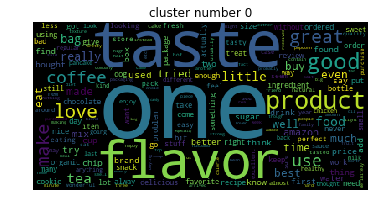

word list for label =  1
10      bought brand online indian grocery store usual...
13      company american classic business years best h...
14      love pico pica adds flavor not hot eat least m...
29      not good yummy smell like cloves cooking taste...
30      good stuff like lentils not need soak small fe...
38      kids love sauce many things great rice chicken...
39      looking good sweet sour sauce chicken based re...
41      not purchase product amazon purchased oz bottl...
42      love stuff put chicken even steaks sweet bit s...
45      sauce excellent blend sweet spicy love eggroll...
46      tried sauce first favorite place eat happy abl...
53      sauce good tastes not hot enough brands tht sl...
58      made crab rangoon used sauce dipping sauce gre...
62      sauce good anything cook grill use dip veggies...
63      whole family loves sauce use primarily recreat...
71      best sauce market use almost food product espe...
75      best sweet chili sauce found anywhere s

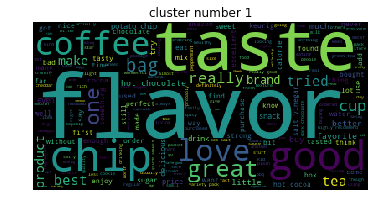

word list for label =  2
1       used victor fly bait seasons ca not beat great...
5       using food months find excellent fact two dogs...
18      purchased item cake called gold dust never tho...
28      good beans not find grocery stores live ordere...
35      first tasted sauce visiting alaska served fish...
55      sauce fine however not resist flagging particu...
67      mentioned give try instant party food frozen m...
77      prefer jerky dry texture always hard time find...
99      not know science diet referred junk food one h...
102                 perfect food cat fact one eat wet dry
103     comes case bought one locally ordering large a...
123     soy milk scrumptious variety extra nutrients a...
133     love water uplifting feel better drinking arse...
134     begun drink penta water unless absolutely necc...
136     best way cook roast local grocery went buisnes...
137     love product cant find locally sometimes littl...
139     great tasting coffiee one best ever pro

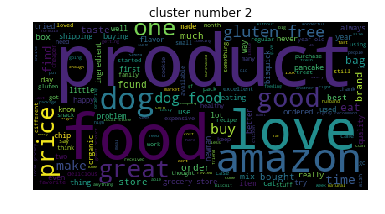

In [122]:
printWordCloud(df,3)

Observation: Cluster 0 : Taste,Cluster 1: Grocery related,cluster 2 : Amimal and personal food choice

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [123]:
aggloWihtK(tfidf_sent_vectors)

For n_clusters = 2 The average silhouette_score is : 0.27948948191504586
For n_clusters = 3 The average silhouette_score is : 0.2750057768563206
For n_clusters = 4 The average silhouette_score is : 0.2818525993789562
For n_clusters = 5 The average silhouette_score is : 0.22236566375888447
For n_clusters = 10 The average silhouette_score is : 0.16642464750728078
For n_clusters = 15 The average silhouette_score is : 0.1558903168346997
For n_clusters = 20 The average silhouette_score is : 0.14872175951287364
For n_clusters = 25 The average silhouette_score is : 0.1523530876563093
For n_clusters = 30 The average silhouette_score is : 0.14403880435020086
For n_clusters = 35 The average silhouette_score is : 0.13179144324220163
For n_clusters = 40 The average silhouette_score is : 0.12500105292529806
For n_clusters = 45 The average silhouette_score is : 0.12735163699228913
For n_clusters = 50 The average silhouette_score is : 0.13000658899725717
The max silhouette_avg is  0.2818525993789562


In [124]:
agg = AgglomerativeClustering(n_clusters=4).fit(tfidf_sent_vectors)

In [125]:
newproce_reviews = np.asarray(preprocessed_reviews)
labels = agg.labels_
df = pd.DataFrame({'desc':newproce_reviews, 'labels':labels})
df.head()

desc  labels
0  product available victor traps unreal course t...       1
1  used victor fly bait seasons ca not beat great...       1
2  received shipment could hardly wait try produc...       1
3  really good idea final product outstanding use...       1
4  glad cocker standard poodle puppy loves stuff ...       1

In [126]:
print(df.labels.unique())

[1 2 0 3]


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

word list for label =  0
8       mix probably not something would want use ever...
10      bought brand online indian grocery store usual...
13      company american classic business years best h...
14      love pico pica adds flavor not hot eat least m...
29      not good yummy smell like cloves cooking taste...
30      good stuff like lentils not need soak small fe...
32      not truly spicy year old loves stuff great chi...
33      go mothers home one day cooked fried chicken r...
37      ever wondered delicious dipping sauce crab won...
39      looking good sweet sour sauce chicken based re...
42      love stuff put chicken even steaks sweet bit s...
45      sauce excellent blend sweet spicy love eggroll...
47      stuff good mom gave bottle go eggrolls hooked ...
49      without doubt finest sweet chilli sic sauce wo...
52      love sauce sweet hot use checken wings instead...
53      sauce good tastes not hot enough brands tht sl...
56      really great sauce slightly expensive s

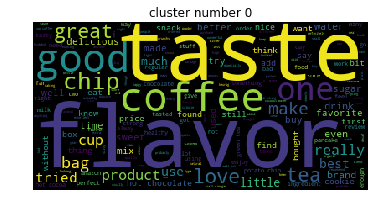

word list for label =  1
0       product available victor traps unreal course t...
1       used victor fly bait seasons ca not beat great...
2       received shipment could hardly wait try produc...
3       really good idea final product outstanding use...
4       glad cocker standard poodle puppy loves stuff ...
6       nine cats crazy kibbles last thing want cat fo...
7       shipped day ordered arrived within days live o...
9       description product disceptive product represe...
11      use keep finicky toddler protein levels great ...
12      get busy home like sausage lot quick meal opti...
15      thank goodness mexgrocer love pico pica sauce ...
16      different sauce nothing like anything find gro...
17      found product search edible gold leaf decided ...
19      used product multiple times fact purchased fou...
20      used super gold luster dust create exquisite c...
21      product allows make really big splashes provid...
22      cute affordable set son golf theme part

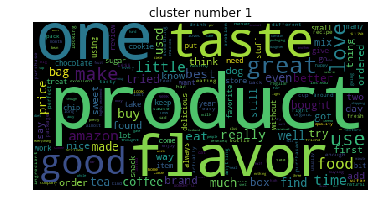

word list for label =  2
5       using food months find excellent fact two dogs...
18      purchased item cake called gold dust never tho...
28      good beans not find grocery stores live ordere...
35      first tasted sauce visiting alaska served fish...
38      kids love sauce many things great rice chicken...
41      not purchase product amazon purchased oz bottl...
46      tried sauce first favorite place eat happy abl...
55      sauce fine however not resist flagging particu...
63      whole family loves sauce use primarily recreat...
67      mentioned give try instant party food frozen m...
71      best sauce market use almost food product espe...
95      review make sound really stupid whatever not r...
98      aged cat sensitive stomach cannot eat cat food...
99      not know science diet referred junk food one h...
102                 perfect food cat fact one eat wet dry
103     comes case bought one locally ordering large a...
115     awesome little snack treat favorite pup

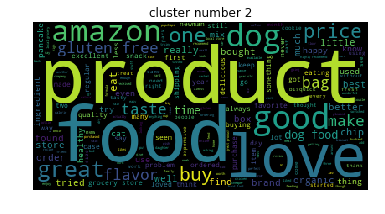

word list for label =  3
24                                                       
121                                                      
456                                                      
601                                                      
718                                                      
792                                                      
820     like plockysthey like us plockys plockys mean ...
1042                                                     
1136                                                     
1183                                                     
1272                                                     
1781                                                     
1816                                                     
2023                                                     
2107                                                     
2353                                                     
Name: desc, dtype: object
Word cloud is not sup

In [127]:
printWordCloud(df,4)

Observation: Cluster 0 : Taste,Cluster 1: Grocery related,cluster 2 : Amimal and personal food choice

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

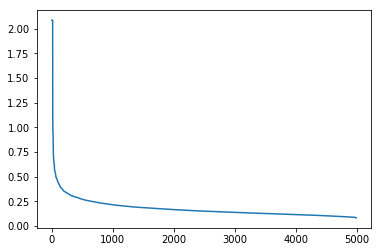

In [128]:
from sklearn.neighbors import NearestNeighbors
ns = 100
nbrs = NearestNeighbors(n_neighbors=ns).fit(sent_vectors)
distances, indices = nbrs.kneighbors(sent_vectors)
distanceDec = sorted(distances[:,ns-1], reverse=True)

plt.plot(list(range(1,4986+1)), distanceDec)

In [129]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.30, min_samples=100).fit(sent_vectors)

In [130]:
newproce_reviews = np.asarray(preprocessed_reviews)
labels = clustering.labels_
df = pd.DataFrame({'desc':newproce_reviews, 'labels':labels})
df.head()

desc  labels
0  product available victor traps unreal course t...       0
1  used victor fly bait seasons ca not beat great...       0
2  received shipment could hardly wait try produc...       0
3  really good idea final product outstanding use...       0
4  glad cocker standard poodle puppy loves stuff ...       0

In [131]:
print(df.labels.unique())

[ 0 -1]


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

24                                                       
121                                                      
378     sooooo deliscious bad ate em fast gained pds f...
381         tasty gluten free option kids loved not spicy
456                                                      
601                                                      
718                                                      
792                                                      
903        salt free product purchased chips quite greasy
1042                                                     
1057    price product certainly raises attention compa...
1127    licorice good taste daughter gluten free diet ...
1136                                                     
1183                                                     
1226    would recommend product received timely manner...
1272                                                     
1485    son gluten free not fun tasty free great puthi...
1528    good p

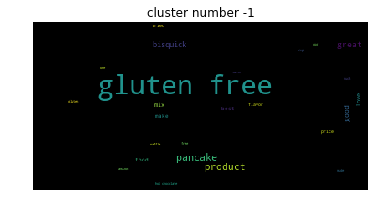

In [132]:
wordslist = df[df['labels'] == -1]['desc']
print(wordslist)
if(len(wordslist) > 0):
    stringlist = " ".join(wordslist)            
    wordcloud = WordCloud(relative_scaling = 1.0,
                      stopwords = set(STOPWORDS)
                      ).generate(stringlist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("cluster number " + str(-1))
    plt.show()

0       product available victor traps unreal course t...
1       used victor fly bait seasons ca not beat great...
2       received shipment could hardly wait try produc...
3       really good idea final product outstanding use...
4       glad cocker standard poodle puppy loves stuff ...
5       using food months find excellent fact two dogs...
6       nine cats crazy kibbles last thing want cat fo...
7       shipped day ordered arrived within days live o...
8       mix probably not something would want use ever...
9       description product disceptive product represe...
10      bought brand online indian grocery store usual...
11      use keep finicky toddler protein levels great ...
12      get busy home like sausage lot quick meal opti...
13      company american classic business years best h...
14      love pico pica adds flavor not hot eat least m...
15      thank goodness mexgrocer love pico pica sauce ...
16      different sauce nothing like anything find gro...
17      found 

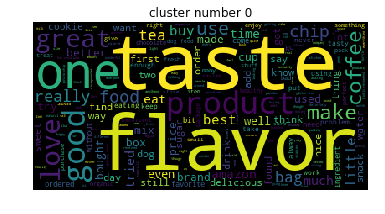

In [133]:
wordslist = df[df['labels'] == 0]['desc']
print(wordslist)
if(len(wordslist) > 0):
    stringlist = " ".join(wordslist)            
    wordcloud = WordCloud(relative_scaling = 1.0,
                      stopwords = set(STOPWORDS)
                      ).generate(stringlist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("cluster number " + str(0))
    plt.show()

Observation: Cluster -1 : Bakery,cluster 1 : Categorized related to taster

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

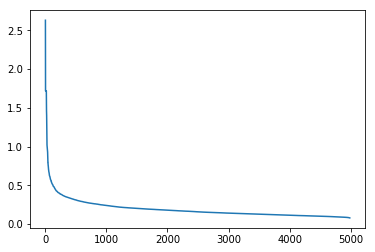

In [134]:
from sklearn.neighbors import NearestNeighbors
ns = 100
nbrs = NearestNeighbors(n_neighbors=ns).fit(tfidf_sent_vectors)
distances, indices = nbrs.kneighbors(tfidf_sent_vectors)
distanceDec = sorted(distances[:,ns-1], reverse=True)

plt.plot(list(range(1,4986+1)), distanceDec)

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

In [135]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.3, min_samples=100).fit(tfidf_sent_vectors)

In [136]:
newproce_reviews = np.asarray(preprocessed_reviews)
labels = clustering.labels_
df = pd.DataFrame({'desc':newproce_reviews, 'labels':labels})
df.head()

desc  labels
0  product available victor traps unreal course t...       0
1  used victor fly bait seasons ca not beat great...       0
2  received shipment could hardly wait try produc...       0
3  really good idea final product outstanding use...       0
4  glad cocker standard poodle puppy loves stuff ...       0

In [137]:
print(df.labels.unique())

[ 0 -1]


Observation: With DBSCAN 2 clusters got created.

24                                                       
28      good beans not find grocery stores live ordere...
121                                                      
133     love water uplifting feel better drinking arse...
381         tasty gluten free option kids loved not spicy
456                                                      
601                                                      
642     baked first batch muffins pleased easy make ta...
644     product comes good company makes number excell...
648     bought local grocery store wish would read rev...
658     recently discovered sensitivities dairy wheat ...
718                                                      
792                                                      
820     like plockysthey like us plockys plockys mean ...
834     favorite gluten free dairy free flavored chips...
853     never met kettle brand chip not like chips gre...
903        salt free product purchased chips quite greasy
906     not ne

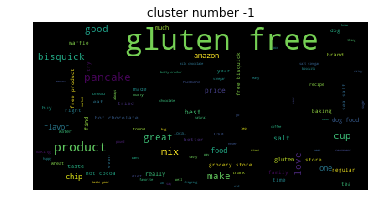

In [138]:
from wordcloud import WordCloud, STOPWORDS 
wordslist = df[df['labels'] == -1]['desc']
print(wordslist)
if(len(wordslist) > 0):
    stringlist = " ".join(wordslist)            
    wordcloud = WordCloud(relative_scaling = 1.0,
                      stopwords = set(STOPWORDS)
                      ).generate(stringlist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("cluster number " + str(-1))
    plt.show()

Observation: Cluster -1 represents 

0       product available victor traps unreal course t...
1       used victor fly bait seasons ca not beat great...
2       received shipment could hardly wait try produc...
3       really good idea final product outstanding use...
4       glad cocker standard poodle puppy loves stuff ...
5       using food months find excellent fact two dogs...
6       nine cats crazy kibbles last thing want cat fo...
7       shipped day ordered arrived within days live o...
8       mix probably not something would want use ever...
9       description product disceptive product represe...
10      bought brand online indian grocery store usual...
11      use keep finicky toddler protein levels great ...
12      get busy home like sausage lot quick meal opti...
13      company american classic business years best h...
14      love pico pica adds flavor not hot eat least m...
15      thank goodness mexgrocer love pico pica sauce ...
16      different sauce nothing like anything find gro...
17      found 

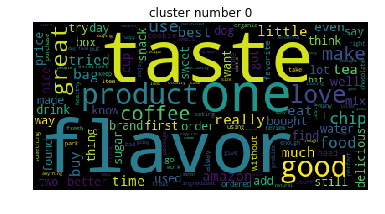

In [139]:
wordslist = df[df['labels'] == 0]['desc']
print(wordslist)
if(len(wordslist) > 0):
    stringlist = " ".join(wordslist)            
    wordcloud = WordCloud(relative_scaling = 1.0,
                      stopwords = set(STOPWORDS)
                      ).generate(stringlist)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("cluster number " + str(0))
    plt.show()

Observation: Cluster -1 : Bakery,cluster 1 : Categorized related to taster

# [6] Conclusions

###  KMEAN Results

| Method | No of samples |No of clusters |
| --- | --- | --- |
| BOW | 5000 | 25 |
| TFIDF | 5000 | 25 |
| AVG W2VE | 5000 | 15 |
| TFIDF W2VE | 50009 | 15 |

### Agglomerative results

| Method | No of samples |No of clusters |
| --- | --- | --- |
| AVG W2VE | 5000 | 3 |
| TFIDF W2VE | 50009 | 2 |

### DBSCAN results

| Method | No of samples |No of clusters |
| --- | --- | --- |
| AVG W2VE | 5000 | 2 |
| TFIDF W2VE | 50009 | 2 |